# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

# Tabla de contenido
- [Importar bibliotecas](#importar_bibliotecas)
- [Cargar y explorar datos](#cargar)
- [Ingeniería de características](#caracteristicas)
- [Entrenamiento de los modelos](#entrenamiento)
    1. [Linear Regression](#linear)
    2. [Random Forest Regressor](#random)
    3. [Light BGM Regressor](#light)
    4. [CatBoost Regressor](#catboost)
    5. [XGB Regressor](#xgb)
- [Análisis de los modelos](#modelos)
- [Conclusión](#conclusion)

## Importar bibliotecas<a name="importar_bibliotecas"></a>

In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import math

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb


## Cargar y explorar datos<a name="cargar"></a>

In [8]:
try:
    df = pd.read_csv('C:/Users/bokol/OneDrive/Desktop/Courses/taxi.csv', index_col=['datetime'], parse_dates=['datetime'])
    
except:
    print("Something went wrong when opening the file")

In [9]:
df.sort_index(inplace=True)

In [10]:
df.isna().sum()

num_orders    0
dtype: int64

In [11]:
print(df.shape)
df.head()

(26496, 1)


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Descripción del DataFrame

Cada observación del conjunto de datos contiene información sobre la fecha y la hora en que se realizaron los pedidos. La información proporcionada es la siguiente:

#### **Características:**

<code style="background:grey;color:black">datetime</code> : Fecha y hora en que se realizaron los pedidos
<br>

#### **Objetivo**

<code style="background:grey;color:black">num_orders</code> : cantidad de pedidos


Hay un total de **26.496 observaciones** y un total de **2 columnas**. 

- El marco de datos consta de **26.496** observaciones y **2 columnas**. El marco de datos consta de pedidos de taxis desde el 1 de marzo de 2018 hasta el 31 de agosto de 2018.

- El Dtype de datos de la columna <code style="background:grey;color:black">datetime</code> estaba en el conjunto de datos original **object**. Durante la carga del archivo, esto se corrigió. Los datos se configuraron en DatetimeIndex y se cambiaron a dtype **Datetime64**

- Además, me aseguré de que los valores de **Datetime** estuvieran ordenados en orden cronológico.

- A continuación, condensaré y agruparé los recorridos en taxi, de modo que en lugar de agruparlos en tandas de 10 minutos, se agruparán por hora.

In [13]:
df = df.resample('1h').sum()

In [14]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Los viajes en taxi ahora se han agrupado en lotes de 1 hora. Esto significa que hemos pasado de **26.496** observaciones a **4416** observaciones. A continuación, investigaremos los datos utilizando la biblioteca **statsmodel**. Aquí investigaré las tendencias, la estacionalidad y los residuos.


En primer lugar, llamaré a los datos de todo el período y, si es necesario, dividiré los datos en períodos de tiempo más cortos.

Text(0.5, 1.0, 'Residuals')

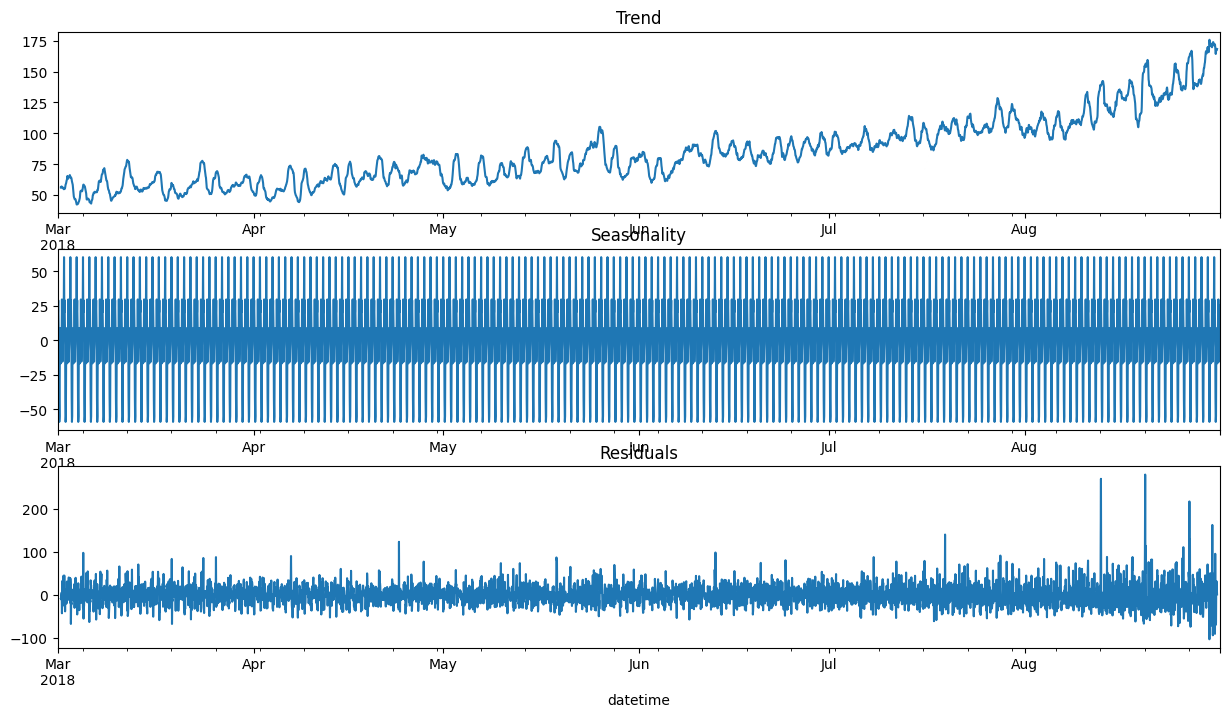

In [16]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(15, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

- **Tendencias:** La menor cantidad de viajes en taxi por hora se registró en marzo y luego aumentó gradualmente durante el período. Durante marzo, abril y mayo, el aumento fue relativamente bajo en comparación con junio, julio y agosto, donde el aumento fue más pronunciado. En marzo, se solicitaron entre 40 y 80 viajes en taxi por hora, mientras que en agosto, se solicitaron entre 100 y 180 viajes en taxi por hora.
- **Estacionalidad**: En términos de estacionalidad, tendré que elegir un marco de tiempo más pequeño para obtener algún significado del gráfico.
- **Residuos:** Los residuos no tienen explicación.

Para entender la estacionalidad, miraré los datos de las últimas 3 dias de agosto.

Text(0.5, 1.0, 'Seasonality')

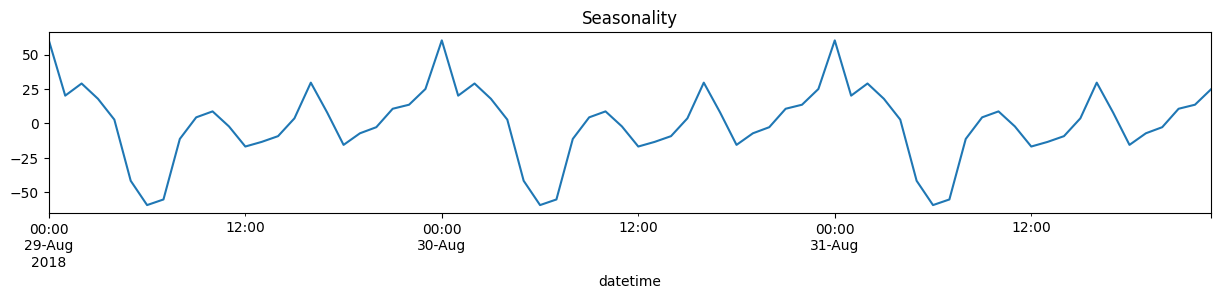

In [17]:
plt.figure(figsize=(15, 8))

plt.subplot(312)
decomposed.seasonal['2018-08-29':'2018-08-31'].plot(ax=plt.gca())
plt.title('Seasonality')

El gráfico muestra ahora un patrón claro. La tendencia muestra que la mayoría de los viajes en taxi se solicitaron alrededor de la medianoche y la menor cantidad se solicitó alrededor de las 6 de la mañana.

Visualmente, la tendencia parece ser el aumento de los viajes a lo largo del tiempo, pero grafiquemos la media móvil y la desviación estándar para obtener una mejor visión.

<Axes: xlabel='datetime'>

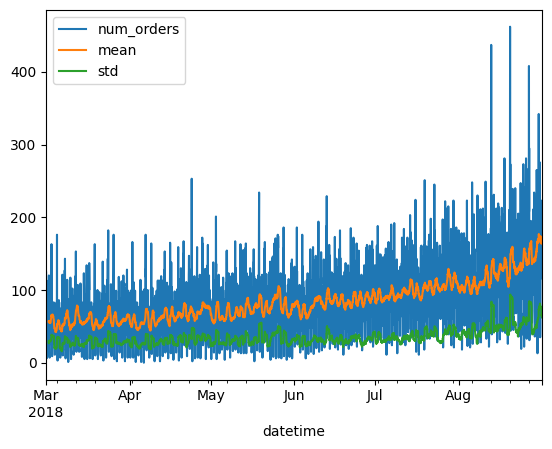

In [18]:
df_plot = df.copy()
df_plot['mean'] = df_plot['num_orders'].rolling(24).mean()
df_plot['std'] = df_plot['num_orders'].rolling(24).std()
df_plot.plot()

Según la media y la desviación estándar, existe una tendencia creciente en los viajes en taxi durante el período. El gráfico anterior indica que esta serie temporal es un proceso estocástico no estacionario.

# Ingeniería de características<a name="caracteristicas"></a>

Es más fácil utilizar datos de series temporales estacionarias para realizar pronósticos, por lo que agregaré algunas columnas donde los datos estén retrasados ​​por una cierta cantidad de horas para ayudar a que los datos sean más estacionarios para los modelos.

La información sobre la fecha/hora y el día de la semana también sería útil, porque esta información está contenida solo en el índice y el modelo puede usar estas características para aprovechar la estacionalidad para sus predicciones.

Una característica con la media móvil de las últimas horas también ayudaría al modelo a identificar la tendencia.

Para la siguiente parte, elijo un retraso máximo de 6 horas porque un cuarto de día parece razonable para predecir los recorridos actuales. Elijo una media móvil de 4 porque la cantidad de recorridos parece cambiar rápidamente y no quiero que el modelo vea demasiado lejos en el pasado.

In [19]:
def lag(df, max_lag):  
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)    
        
def rolling_mean(df, mean_size):
    df['rolling_mean'] = df['num_orders'].shift().rolling(mean_size).mean()

In [20]:
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

In [21]:
lag(df, max_lag=6)
rolling_mean(df, mean_size=4)

In [22]:
df.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN,86.5


La tabla ahora se ve como se muestra arriba. Los valores NaN en las primeras filas se eliminarán antes de dividir los datos en conjuntos de prueba y de entrenamiento.

In [23]:
df.dropna(inplace=True)

Ahora estoy listo para entrenar los modelos.

# Entrenamiento de los modelos<a name="entrenamiento"></a>

En esta sección entrenaremos diferentes modelos y ajustaremos algunos hiperparámetros, si es posible, por supuesto. Usaremos los siguientes algoritmos:

- LinearRegression
- RandomForestRegressor (con diferentes n_estimators y max_depth)
- LightBGMRegressor (con diferentes n_estimators y max_depth)
- XGBoostRegressor (con diferentes n_estimators y max_depth)
- CatBoostRegressor (con diferente número de iteraciones y profundidad)

### Separación de características y objetivo.

In [24]:
X = df.num_orders
y = df.drop('num_orders', axis=1)

### Creacion de datasets para entrenamiento y prueba.

In [25]:
X, y = train_test_split(df, shuffle=False, test_size=0.1)

In [26]:
X_train = X['num_orders']  
y_train = X.drop('num_orders', axis=1)
X_test = y['num_orders']
y_test = y.drop('num_orders', axis=1)

In [27]:
X_train = np.array(X_train).reshape(-1,1)

### Linear Regression<a name="linear"></a>

In [28]:
model = LinearRegression()
model.fit(y_train, X_train)
pred_train = model.predict(y_train)
pred_test = model.predict(y_test)

rmse_score_lr_train = math.sqrt(mean_squared_error(X_train, pred_train))
rmse_score_lr_test = math.sqrt(mean_squared_error(X_test, pred_test))


print(f'La puntuación RMSE en el conjunto de prueba del modelo de regresión lineal es {rmse_score_lr_test}.')
print(f'La puntuación RMSE en el conjunto de entrenamiento del modelo de regresión lineal es {rmse_score_lr_train}.')

La puntuación RMSE en el conjunto de prueba del modelo de regresión lineal es 53.278266542913165.
La puntuación RMSE en el conjunto de entrenamiento del modelo de regresión lineal es 30.467560251661098.


El modelo de regresión lineal obtuvo una puntuación **RMSE de 53**, que está por encima del umbral de 48. Continuaré con otros modelos para ver si podemos encontrar uno más adecuado a las necesidades de la empresa.

### Random Forest Regressor<a name="random"></a>

Primero crearé una función para buscar los parámetros óptimos para el modelo.

In [23]:
# Encuentra los parámetros óptimos para el modelo
# Definir cuadrícula de parámetros
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth' : [10, 20, 50, 100],
}

# Inicializar GridSearchCV
clf = GridSearchCV(RandomForestRegressor(random_state=12345), param_grid)

# Fit model
clf.fit(X_train, y_train)

# Mejores parámetros y puntuación
print(f'Best parameters: {clf.best_params_}')

Best parameters: {'max_depth': 10, 'n_estimators': 200}


In [29]:
model = RandomForestRegressor(random_state=12345, n_estimators=200,max_depth=10)
rf_model = model.fit(y_train, X_train.ravel())
pred_train = model.predict(y_train)
pred_test = model.predict(y_test)

rmse_score_rf_train = math.sqrt(mean_squared_error(X_train, pred_train))
rmse_score_rf_test = math.sqrt(mean_squared_error(X_test, pred_test))

print(f'La puntuación RMSE en el conjunto de prueba del modelo de bosque aleatorio es {rmse_score_rf_test}.')
print(f'La puntuación RMSE en el conjunto de entrenamiento del modelo de bosque aleatorio es {rmse_score_rf_train}.')

La puntuación RMSE en el conjunto de prueba del modelo de bosque aleatorio es 46.383607243154344.
La puntuación RMSE en el conjunto de entrenamiento del modelo de bosque aleatorio es 15.429022071588447.


El modelo Regresor de Bosque Aleatorio obtuvo una puntuación **RMSE de 46**, que está por debajo del umbral establecido por la empresa.

### Light BGM Regressor<a name="light"></a>

Primero crearé una función para buscar los parámetros óptimos para el modelo.

In [25]:
# Encuentra los parámetros óptimos para el modelo
# Definir cuadrícula de parámetros
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth' : [10, 20, 50, 100],
    'num_leaves': [10, 20, 50, 100],
}

# Inicializar GridSearchCV
clf = GridSearchCV(LGBMRegressor(random_state=12345, force_col_wise=True), param_grid)

# Fit model
clf.fit(X_train, X_train.ravel())

# Mejores parámetros y puntuación
print(f'Best parameters: {clf.best_params_}')

[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 3175, number of used features: 1
[LightGBM] [Info] Start training from score 83.609449
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 3175, number of used features: 1
[LightGBM] [Info] Start training from score 81.809764
[LightGBM] [Info] Total Bins 185
[LightGBM] [Info] Number of data points in the train set: 3175, number of used features: 1
[LightGBM] [Info] Start training from score 79.031811
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 3175, number of used features: 1
[LightGBM] [Info] Start training from score 75.845669
[LightGBM] [Info] Total Bins 169
[LightGBM] [Info] Number of data points in the train set: 3176, number of used features: 1
[LightGBM] [Info] Start training from score 71.282746
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 3175, number of use

In [30]:
model = LGBMRegressor(random_state=12345, n_estimators=200,max_depth=10, num_leaves = 50, force_col_wise=True)
lgb_model = model.fit(y_train, X_train.ravel())
pred_train = model.predict(y_train)
pred_test = model.predict(y_test)

rmse_score_lg_train = math.sqrt(mean_squared_error(X_train, pred_train))
rmse_score_lg_test = math.sqrt(mean_squared_error(X_test, pred_test))

print(f'La puntuación RMSE en el conjunto de prueba del modelo de lightgbm es {rmse_score_lg_test}.')
print(f'La puntuación RMSE en el conjunto de entrenamiento del modelo de lightgbm es {rmse_score_lg_train}.')

[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 11
[LightGBM] [Info] Start training from score 78.315445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

El modelo Light BGM Regressor obtuvo una puntuación **RMSE de 46**, que está por debajo del umbral establecido por la empresa.

### CatBoost Regressor<a name="catBoost"></a>

Primero crearé una función para buscar los parámetros óptimos para el modelo.

In [27]:
# Encuentra los parámetros óptimos para el modelo
# Definir cuadrícula de parámetros
param_grid = {
    'iterations': [100, 200, 500],
    'depth' : [5, 10, 15],
}

# Inicializar GridSearchCV
clf = GridSearchCV(CatBoostRegressor(random_state=12345), param_grid, verbose=0)

# Fit model
clf.fit(y_train, X_train.ravel())

# Mejores parámetros y puntuación
print(f'Best parameters: {clf.best_params_}')
print(f'Best score: {clf.best_score_}')

Learning rate set to 0.319488
0:	learn: 33.6307409	total: 152ms	remaining: 15s
1:	learn: 30.9459389	total: 153ms	remaining: 7.51s
2:	learn: 28.6986179	total: 155ms	remaining: 5s
3:	learn: 27.5852665	total: 156ms	remaining: 3.74s
4:	learn: 26.6723679	total: 157ms	remaining: 2.98s
5:	learn: 25.7342848	total: 158ms	remaining: 2.47s
6:	learn: 25.2285514	total: 159ms	remaining: 2.11s
7:	learn: 24.8656155	total: 160ms	remaining: 1.84s
8:	learn: 24.5842957	total: 161ms	remaining: 1.63s
9:	learn: 24.4515576	total: 162ms	remaining: 1.46s
10:	learn: 24.2258467	total: 163ms	remaining: 1.32s
11:	learn: 24.0388612	total: 164ms	remaining: 1.2s
12:	learn: 23.9779417	total: 165ms	remaining: 1.11s
13:	learn: 23.9003189	total: 167ms	remaining: 1.02s
14:	learn: 23.6897463	total: 168ms	remaining: 951ms
15:	learn: 23.6324514	total: 169ms	remaining: 887ms
16:	learn: 23.2257212	total: 170ms	remaining: 830ms
17:	learn: 22.7760832	total: 171ms	remaining: 779ms
18:	learn: 22.6738864	total: 172ms	remaining: 733m

In [31]:
model = CatBoostRegressor(random_state=12345, iterations=500, 
                                       depth=5, verbose=0)
cb_model = model.fit(y_train, X_train.ravel())
pred_train = model.predict(y_train)
pred_test = model.predict(y_test)


rmse_score_cb_train = math.sqrt(mean_squared_error(X_train, pred_train))
rmse_score_cb_test = math.sqrt(mean_squared_error(X_test, pred_test))


print(f'La puntuación RMSE en el conjunto de prueba del modelo de CatBoost es {rmse_score_cb_test}.')
print(f'La puntuación RMSE en el conjunto de entrenamiento del modelo de CatBoost es {rmse_score_cb_train}.')


La puntuación RMSE en el conjunto de prueba del modelo de CatBoost es 44.7082927755485.
La puntuación RMSE en el conjunto de entrenamiento del modelo de CatBoost es 15.618060078359166.


El modelo CatBoost Regressor obtuvo una puntuación **RMSE de 44**, que está por debajo del umbral establecido por la empresa.

### XGB Regressor<a name="xgb"></a>

Primero crearé una función para buscar los parámetros óptimos para el modelo.

In [29]:
# Encuentra los parámetros óptimos para el modelo
# Definir cuadrícula de parámetros
param_grid = {
    'n_estimators': [None, 30, 50, 100],
    'max_depth' : [None, 5, 10, 20],
}

# Inicializar GridSearchCV
clf = GridSearchCV(xgb.XGBRegressor(random_state=12345), param_grid, cv=5, verbose=True, n_jobs=-1)

# Fit model
clf.fit(X_train, y_train)

# Mejores parámetros y puntuación
print(f'Best parameters: {clf.best_params_}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'max_depth': 5, 'n_estimators': 30}


In [32]:
model = xgb.XGBRegressor(random_state=12345, n_estimators=30,max_depth=5)
lgb_model = model.fit(y_train, X_train.ravel())
pred_train = model.predict(y_train)
pred_test = model.predict(y_test)

rmse_score_xg_train = math.sqrt(mean_squared_error(X_train, pred_train))
rmse_score_xg_test = math.sqrt(mean_squared_error(X_test, pred_test))


print(f'La puntuación RMSE en el conjunto de prueba del modelo de xgboost es {rmse_score_xg_test}.')
print(f'La puntuación RMSE en el conjunto de entrenamiento del modelo de xgboost es {rmse_score_xg_train}.')

La puntuación RMSE en el conjunto de prueba del modelo de xgboost es 47.04571880609512.
La puntuación RMSE en el conjunto de entrenamiento del modelo de xgboost es 15.802713891566924.


El modelo CatBoost Regressor obtuvo una puntuación **RMSE de 44**, que está por debajo del umbral establecido por la empresa.

# Análisis del modelo<a name="modelos"></a>

A continuación, compararé la puntuación RMSE de los modelos.

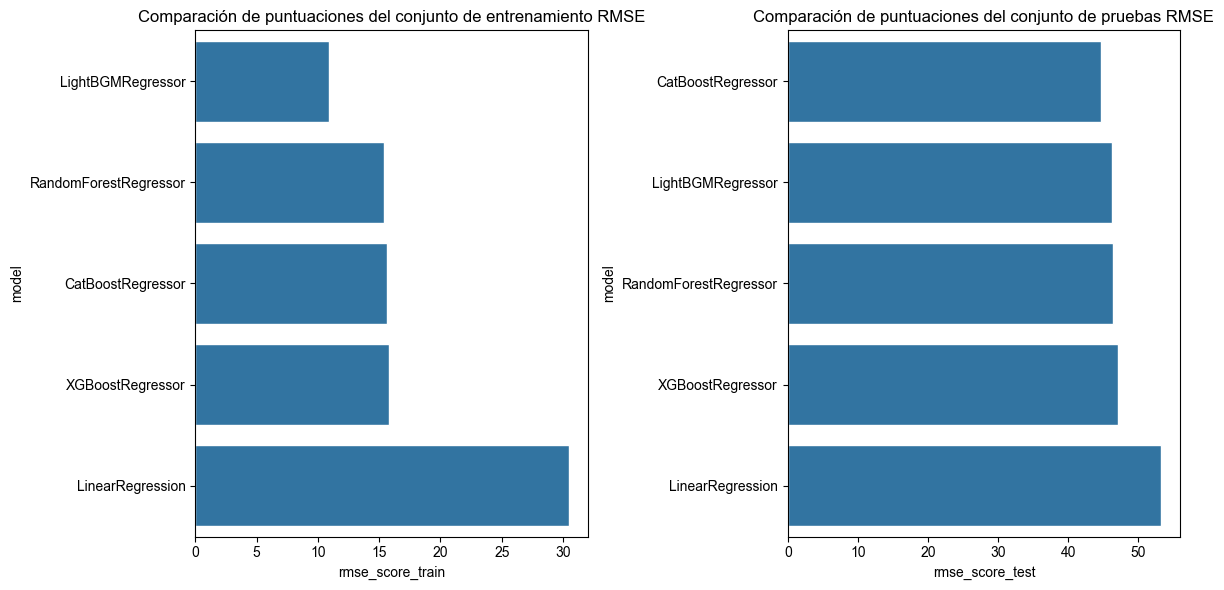

In [33]:
# Rendimiento de los mejores modelos
models = ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LightBGMRegressor', 'XGBoostRegressor',]
rmse_score_train = [rmse_score_lr_train, rmse_score_rf_train, rmse_score_cb_train, rmse_score_lg_train, rmse_score_xg_train]
rmse_score_test = [rmse_score_lr_test, rmse_score_rf_test, rmse_score_cb_test, rmse_score_lg_test, rmse_score_xg_test]

# crear un marco de datos
df_comparison = pd.DataFrame(
    data=zip(models, rmse_score_train, rmse_score_test),
    columns=["model", "rmse_score_train", "rmse_score_test"],
).sort_values("rmse_score_test")

# Métricas de rendimiento de la trama
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("darkgrid")

sns.barplot(
    data=df_comparison.sort_values("rmse_score_train"),
    y="model",
    x="rmse_score_train",
    orient="h",
    ax=ax[0],
)
ax[0].set_title("Comparación de puntuaciones del conjunto de entrenamiento RMSE")

sns.barplot(
    data=df_comparison.sort_values("rmse_score_test"),
    y="model",
    x="rmse_score_test",
    orient="h",
    ax=ax[1],
)
ax[1].set_title("Comparación de puntuaciones del conjunto de pruebas RMSE")

plt.tight_layout()
plt.show()

In [34]:
df_comparison

,model,rmse_score_train,rmse_score_test
2,CatBoostRegressor,15.618060,44.708293
3,LightBGMRegressor,10.927167,46.200058
1,RandomForestRegressor,15.429022,46.383607
4,XGBoostRegressor,15.802714,47.045719
0,LinearRegression,30.467560,53.278267


**Observaciones:**
En general, se puede decir que logré obtener puntajes RMSE por debajo del umbral de la empresa de **48** para 4 de los 5 modelos.
1. El modelo Catboost Regressor fue el modelo con mejor rendimiento. El modelo Catboost Regressor alcanzó una puntuación **RMSE de 44,7**
2. El segundo mejor modelo fue el modelo Light BGM Regressor, que obtuvo una puntuación **RMSE de 46,2**
3. El tercer mejor modelo fue el modelo Random Forest Regressor, que alcanzó una puntuación **RMSE de 46,3**
4. El cuarto mejor modelo fue el modelo XG Boost Regressor, que obtuvo una puntuación **RMSE de 47,0**
5. El peor modelo fue el modelo Linear Regressor, que alcanzó una puntuación **RMSE de 53,2**

# Conclusión<a name="conclusion"></a>


En este proyecto, he creado un modelo para predecir el número de pedidos de taxis por hora para la empresa Sweet Lift Taxi. Después de limpiar y preparar los datos, construí y probé varios modelos diferentes y realicé un ajuste de parámetros en cada uno para encontrar el modelo con la puntuación RMSE más baja. Después del entrenamiento y el ajuste, comparé los modelos y el modelo con la puntuación RMSE más baja fue el modelo Catboost, que obtuvo una puntuación RMSE de 44,7, muy por debajo del umbral de la empresa de 48 RMSE.

Con el modelo Catboost, Sweet Lift Taxi puede predecir de forma fiable el número de pedidos de taxis por hora. La empresa puede utilizar esta información para distribuir a sus conductores de forma más eficiente y planificar la cantidad de taxis necesarios, lo que les permitirá reducir el tiempo de espera de los pasajeros, alcanzar un número óptimo de conductores en servicio, mejorar la satisfacción del cliente y, en última instancia, aumentar sus ganancias.